# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'

In [4]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'loss': 'hinge',
    'penalty': 'l2'
}
param_grid = {
    'C': [10 ** x for x in range(-5, 2)],
    'intercept_scaling': [10 ** x for x in range(-5, 2)],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
if not os.path.exists('data'):
    os.makedirs('data')

In [6]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [7]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 20s, sys: 1.01 s, total: 1min 21s
Wall time: 1min 21s


In [8]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 15s, sys: 1.22 s, total: 1min 16s
Wall time: 1min 16s


In [9]:
y = Y[GENE]

In [10]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [11]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

## Set aside 10% of the data for testing

In [12]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Median absolute deviation feature selection

In [13]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [14]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = LinearSVC(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [15]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 15.6 s, sys: 3.2 s, total: 18.8 s
Wall time: 2min


In [16]:
clf_grid.best_params_

{'C': 0.01, 'intercept_scaling': 1}

In [17]:
best_clf

LinearSVC(C=0.01, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=0)

## Visualize hyperparameters performance

In [18]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [19]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,C,fold,intercept_scaling,score
0,0.00001,0,0.00001,0.742723
1,0.00001,1,0.00001,0.745136


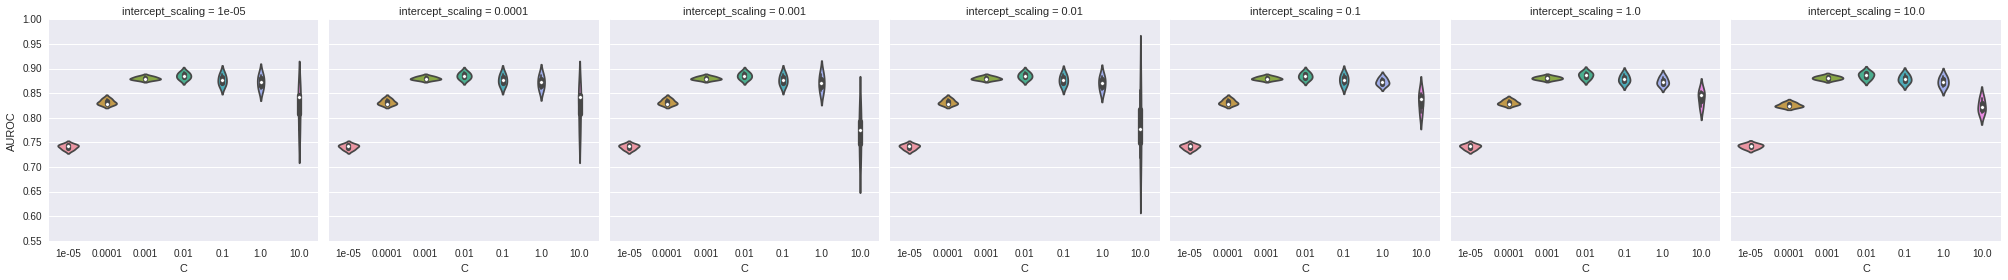

In [20]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='C', y='score', col='intercept_scaling',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

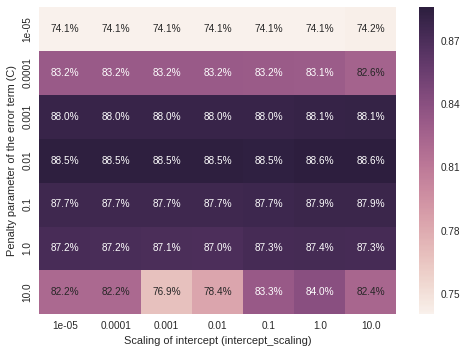

In [21]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='C', columns='intercept_scaling')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Scaling of intercept (intercept_scaling)')
ax.set_ylabel('Penalty parameter of the error term (C)');

## Use Optimal Hyperparameters to Output ROC Curve

In [22]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

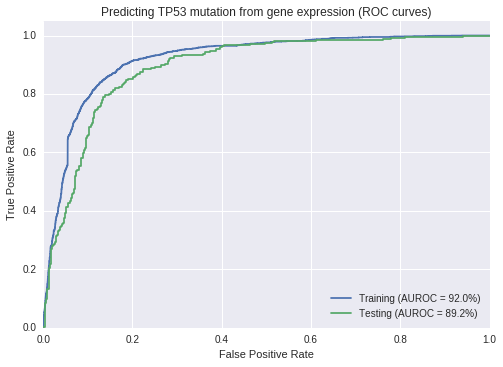

In [23]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [24]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [25]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'0.0% zero coefficients; 254 negative and 246 positive coefficients'

In [26]:
coef_df.head(10)

,weight,abs
PVRL4,-0.335244,0.335244
FUT3,0.291022,0.291022
MMP7,0.249358,0.249358
HES2,-0.244722,0.244722
MLXIPL,0.237639,0.237639
GPR158,0.236366,0.236366
ATP10B,0.232145,0.232145
COL11A1,0.216597,0.216597
AFF3,-0.214706,0.214706
C9orf152,0.195311,0.195311


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. This makes finding a transcriptional signature fairly easy. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...

## Investigate the predictions

In [27]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict(X)),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [28]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-B6-A0I1-01,TCGA-B6-A0I1-01,0,0,3.975921,1,100.0%
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,3.572769,1,100.0%
TCGA-49-6743-01,TCGA-49-6743-01,1,0,3.558552,1,100.0%
TCGA-CV-5441-01,TCGA-CV-5441-01,1,0,3.546549,1,100.0%
TCGA-AO-A1KR-01,TCGA-AO-A1KR-01,0,0,3.192553,1,100.0%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,3.172224,1,100.0%
TCGA-61-1907-01,TCGA-61-1907-01,0,0,3.072827,1,100.0%
TCGA-EW-A1P8-01,TCGA-EW-A1P8-01,0,0,3.067012,1,100.0%
TCGA-AN-A0XU-01,TCGA-AN-A0XU-01,0,0,3.041163,1,100.0%


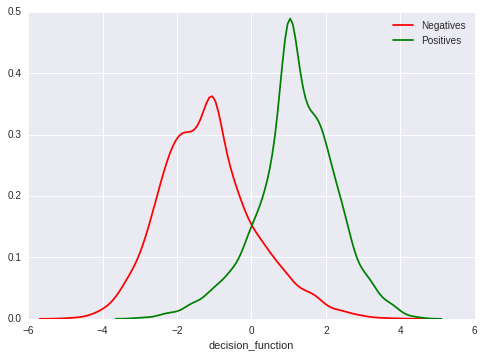

In [29]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives', color = 'red')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives', color = 'green')

In [30]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(predict_df.query("testing == 1").status, 
                            predict_df.query("testing == 1").probability, 
                            labels = [1, 0])
cols = {'Pos': conf_mat[:,0].tolist(), 'Neg': conf_mat[:,1].tolist()}
df_conf = pd.DataFrame(cols, index = ['Pos', 'Neg'])[['Pos', 'Neg']]
df_conf.index.name = 'Label / Predict'
df_conf

,Pos,Neg
Label / Predict,,
Pos,234,39
Neg,102,396


In [31]:
from sklearn.metrics import f1_score
f1 = f1_score(predict_df.query("testing == 1").status, predict_df.query("testing == 1").probability)
'The F1 score is {:.3}'.format(f1)

'The F1 score is 0.768'